<a href="https://colab.research.google.com/github/SNOOR7/AICW/blob/main/code2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import keras

!pip install matplotlib
!pip install copy


ERROR: Could not find a version that satisfies the requirement copy (from versions: none)
ERROR: No matching distribution found for copy


Load Data

In [1]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Get pixel gradienrt values

In [ ]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0


Convert Labels

In [7]:
def one_hot_encoding(labels, num_classes):
    num_samples = len(labels)
    encoded_labels = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        encoded_labels[i, labels[i]] = 1
    return encoded_labels


num_classes = 10
y_train_one_hot = one_hot_encoding(y_train, num_classes)
y_test_one_hot = one_hot_encoding(y_test, num_classes)


Data Visualization

In [8]:
num_classes = 10
y_train_one_hot = one_hot_encoding(y_train, num_classes)
y_test_one_hot = one_hot_encoding(y_test, num_classes)

# Activation Functions and Their Derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))


def relu(x):
    return np.maximum(0, x)


def relu_derivative(x):
    return np.where(x > 0, 1, 0)

Dropout and softmax

In [9]:
def softmax(x):
    exponent_vals = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exponent_vals / np.sum(exponent_vals, axis=1, keepdims=True)


class Dropout:
    def __init__(self, dropout_rate):
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, x, training=True):
        if training:
            self.mask = (
                np.random.rand(*x.shape) < self.dropout_rate
            ) / self.dropout_rate
            return x * self.mask
        else:
            return x

    def backward(self, grad):
        return grad * self.mask



In [30]:
print("Input shape:", x_train.shape)

Input shape: (60000, 28, 28)


In [31]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i} shape: {layer.shape}")

Layer 0 shape: (28, 128)
Layer 1 shape: (128, 64)
Layer 2 shape: (64, 10)


Neural Network

In [74]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_layers, output_size, activation="relu", dropout_rate=0.0):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.layers = []
        self.activation = activation
        self.dropout = Dropout(dropout_rate)
        self.build_network()

    def build_network(self):
        layer_sizes = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layer_sizes) - 1):
            self.layers.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01)

    def forwardPass(self, x, training=True):
        layer_output = x
        self.layer_outputs = [layer_output]
        for layer in self.layers:
            layer_output = np.dot(layer_output, layer)
            if self.activation == "relu":
                layer_output = relu(layer_output)
            elif self.activation == "sigmoid":
                layer_output = sigmoid(layer_output)
            self.layer_outputs.append(layer_output)
            if training:
                layer_output = self.dropout.forward(layer_output, training)
        return softmax(layer_output)

    def backwardPass(self, x, y):
        gradients = []
        predictions = self.forwardPass(x, training=True)
        num_samples = x.shape[0]
        output_error = predictions - y

        for i in reversed(range(len(self.layers))):
            if self.activation == "relu":
                derivative = relu_derivative(self.layer_outputs[i + 1])
            elif self.activation == "sigmoid":
                derivative = sigmoid_derivative(self.layer_outputs[i + 1])
            else:
                derivative = 1
            grad = (np.dot(self.layer_outputs[i].T, output_error * derivative) / num_samples)
            gradients.append(grad)
            output_error = np.dot(output_error * derivative, self.layers[i].T)
        gradients.reverse()
        return gradients

    def updateWeights(self, gradients, learning_rate):
        for i in range(len(self.layers)):
            self.layers[i] -= learning_rate.learning_rate * gradients[i]

    def computeLoss(self, predictions, targets):
        num_samples = predictions.shape[0]
        loss = -np.sum(targets * np.log(predictions + 1e-10)) / num_samples
        return loss

    def train(self, x_train, y_train, x_test, y_test, epochs, batch_size, learning_rate):
        train_losses, train_accuracies, test_accuracies = [], [], []

        for epoch in range(epochs):
            total_loss = 0.0
            for i in range(0, len(x_train), batch_size):
                x_batch = x_train[i: i + batch_size]
                y_batch = y_train[i: i + batch_size]
                grad = self.backwardPass(x_batch, y_batch)
                self.updateWeights(grad, learning_rate)

                predictions = self.forwardPass(x_batch, training=False)
                batch_loss = self.computeLoss(predictions, y_batch)
                total_loss += batch_loss

            avg_loss = total_loss / (len(x_train) // batch_size)
            train_losses.append(avg_loss)

            train_pred = np.argmax(self.forwardPass(x_train, training=False), axis=1)
            train_acc = np.mean(train_pred == np.argmax(y_train, axis=1))
            test_pred = np.argmax(self.forwardPass(x_test, training=False), axis=1)
            test_acc = np.mean(test_pred == np.argmax(y_test, axis=1))

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)

            print(f'Epoch {epoch}: Loss = {avg_loss:.4f}, Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}')

        return train_losses, train_accuracies, test_accuracies





Optimizer

In [50]:
class Optimizer:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, layers, gradients):
        pass


class SGD(Optimizer):
    def update(self, layers, gradients):
        for i in range(len(layers)):
            layers[i] -= self.learning_rate * gradients[i]


class Momentum(Optimizer):
    def __init__(self, layers, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocities = [np.zeros_like(layer) for layer in layers]

    def update(self, layers, gradients):
        for i in range(len(layers)):
            self.velocities[i] = (
                self.momentum * self.velocities[i] - self.learning_rate * gradients[i]
            )
            layers[i] += self.velocities[i]


In [43]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

In [44]:
print("x_train shape:", x_train.shape)


x_train shape: (60000, 784)


Test

Epoch 0: Loss = 2.5561, Train Acc = 0.0987, Test Acc = 0.0980


<ipython-input-9-f78d785a0ad1>:16: RuntimeWarning: invalid value encountered in multiply
  return x * self.mask


Epoch 1: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 2: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 3: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 4: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 5: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 6: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 7: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 8: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 9: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 10: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 11: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 12: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 13: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 14: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 15: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 16: Loss = nan, Train Acc = 0.0987, Test Acc = 0.0980
Epoch 17: Loss = nan, Train Acc = 0.0987, Test Ac

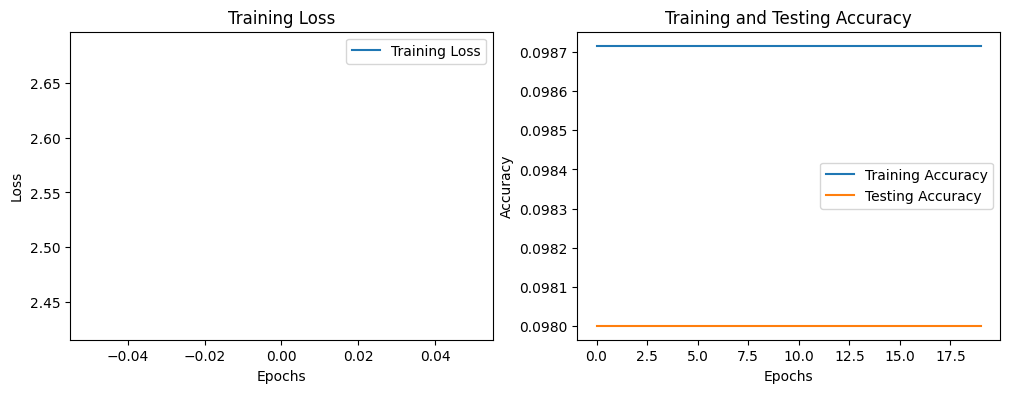

In [67]:
# Define hyperparameters
input_size = 784  # 28x28 pixels flattened
hidden_layers = [128, 64]
output_size = num_classes
epochs = 200
batch_size = 64
learning_rate = 0.01

# Create Neural Network instance with sigmoid activation
model = NeuralNetwork(input_size, hidden_layers, output_size, activation="relu", dropout_rate=0.2)

# Choose the optimizer
optimizer = SGD(learning_rate)
# Or use Momentum optimizer
# optimizer = Momentum(model.layers, learning_rate)

# Train the model
train_losses, train_accuracies, test_accuracies = model.train(
    x_train, y_train_one_hot, x_test, y_test_one_hot, epochs, batch_size, optimizer
)

# Plotting
epochs_range = range(epochs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, test_accuracies, label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()